<a href="https://colab.research.google.com/github/ueki5/colaboratory/blob/main/playground-014.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1
!pip install japanize-matplotlib | tail -n 1


元データ (150, 4) (150,)
対象データ (100, 2) (100,)
(70, 2) (30, 2) (70,) (30,)


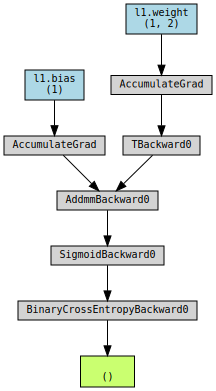

AttributeError: module 'matplotlib.pyplot' has no attribute 'ylable'

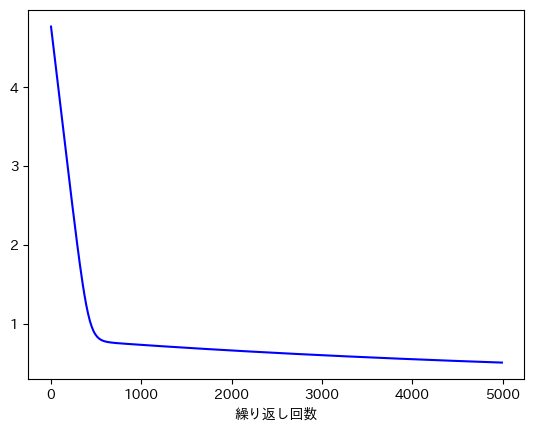

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import torch
from torchinfo import summary
from torchviz import make_dot

# # シグモイド関数
# x_np = np.arange(-4, 4.1, 0.25)
# x = torch.tensor(x_np).float()
# y = torch.sigmoid(x)

# plt.title('シグモイド関数のグラフ')
# plt.plot(x.data, y.data)
# plt.show()

# データ準備

from sklearn.datasets import load_iris

# データ読み込み
iris = load_iris()

# 入力データと正解データ取得
x_org, y_org = iris.data, iris.target

# 結果確認
print('元データ', x_org.shape, y_org.shape)
# print(x_org)
# print(y_org)

# データ絞り込み
#  クラス0,1のみ
#  項目 sepal_lengthとsepal_widthのみ

x_data = iris.data[:100, :2]
y_data = iris.target[:100]

# 結果確認
print('対象データ', x_data.shape, y_data.shape)
# print(x_data)
# print(y_data)

# 訓練データ、検証データに分割（シャッフルも同時に実施）
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, train_size=70, test_size=30,
    random_state=123
)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
# print('x_train\n',x_train)
# print('y_train\n',y_train)
# print('x_test\n',x_test)
# print('y_test\n',y_test)

# # 散布図の表示（訓練データ）
# x_t0 = x_train[y_train == 0]
# x_t1 = x_train[y_train == 1]
# plt.scatter(x_t0[:,0], x_t0[:,1], marker='x', c='b', label='0(setosa)')
# plt.scatter(x_t1[:,0], x_t1[:,1], marker='o', c='k', label='1(versicolor)')
# plt.xlabel('sepal_length')
# plt.ylabel('sepal_width')
# plt.legend()
# plt.show()

# # 散布図の表示（教師データ）
# x_e0 = x_test[y_test == 0]
# x_e1 = x_test[y_test == 1]
# plt.scatter(x_e0[:,0], x_e0[:,1], marker='x', c='b', label='0(setosa)')
# plt.scatter(x_e1[:,0], x_e1[:,1], marker='o', c='k', label='1(versicolor)')
# plt.xlabel('sepal_length')
# plt.ylabel('sepal_width')
# plt.legend()
# plt.show()

###################################################
# 強化学習
###################################################
lr = 0.001  # 学習率
num_epochs = 5000 # 繰り返し回数
num_history = 10 # 履歴採取タイミング

# 学習データ
inputs = torch.tensor(x_train).float()
labels = torch.tensor(y_train).float().view(-1,1)

# 検証データ
inputs_t = torch.tensor(x_test).float()
labels_t = torch.tensor(y_test).float().view(-1,1)

# 予測計算クラス
n_input = x_train.shape[1]
n_output = 1
class Net(torch.nn.Module):
  # 初期化
  def __init__(self, n_input, n_output):
    super().__init__()
    # 予測関数を生成
    self.l1 = torch.nn.Linear(n_input, n_output) # 初段
    # 重み、バイアスの初期値を設定
    # torch.nn.init.constant_(self.l1.weight, 1.0)
    # torch.nn.init.constant_(self.l1.bias, 1.0)
    self.l1.weight.data.fill_(1.0)
    self.l1.bias.data.fill_(1.0)
    # print(f"self.l1.weight.shape:{self.l1.weight.shape}")
    # print(f"self.l1.weight:{self.l1.weight}")
    # print(f"self.l1.bias.shape:{self.l1.bias.shape}")
    # print(f"self.l1.bias:{self.l1.bias}")

    # 活性化関数
    self.sig = torch.nn.Sigmoid()

    # 関数合成
    self.net = torch.nn.Sequential(
        self.l1,
        self.sig,
    )

  # 予測関数
  def forward(self, inputs):
    outputs = self.net(inputs)
    return outputs

# 予測計算オブジェクト
net = Net(n_input, n_output)

# 損失関数
criterion = torch.nn.BCELoss()

# 最適化関数
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# 記録用配列初期化
history = np.zeros((0, 2))

# 繰り返し処理
for epoch in range(num_epochs):

  # 予測計算
  outputs = net(inputs)

  # 損失計算
  loss = criterion(outputs, labels)
  if epoch == 0:
    g = make_dot(loss, params = dict(net.named_parameters()))
    display(g)

  # 勾配計算
  loss.backward()

  # パラメータ調整＆勾配クリア
  optimizer.step()
  optimizer.zero_grad()

  # 学習曲線データの登録
  if epoch % num_history == 0:
    item = np.array([epoch, loss.item()])
    history = np.vstack((history, item))

# 学習曲線グラフ
plt.plot(history[:,0], history[:,1], 'b')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線（損失）')
plt.show()
